In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8) #그림 그리기 위해서는 0과 1사이 실수 or 0과 256 사이에 int

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

In [22]:
def deprocess(img):
  img = 255*(img)/np.max(img)
  return tf.cast(img, tf.uint8) #그림 그리기 위해서는 0과 1사이 실수 or 0과 256 사이에 int

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

In [3]:
model = VGG19(weights='imagenet', include_top=False)
print('Model loaded.')

model.summary()

2022-11-22 10:59:04.421634: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 10:59:08.156592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11402 MB memory:  -> device: 0, name: TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1


80150528/80134624 [==============================] - 4s 0us/step
Model loaded.
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                

In [4]:
layers = model.get_layer('block5_pool').output 

dream_model = tf.keras.Model(inputs=model.input, outputs=layers)

In [5]:
def calc_loss(img, model):
  
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  loss = tf.reduce_mean(layer_activations[:,:,:,0])
  return  loss

In [36]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          tape.watch(img)
          loss = calc_loss(img, self.model)

       
        gradients = tape.gradient(loss, img)

        
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        
        img = img + gradients*step_size
        img = tf.clip_by_value(img, 0,255)

      return loss, img

In [32]:
deepdream = DeepDream(dream_model)

In [16]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  img = tf.keras.applications.vgg19.preprocess_input(img)
  #img = tf.convert_to_tensor(img)
  loss, img = deepdream(img, steps, step_size)
  result = deprocess(img)
  show(result)

  return result

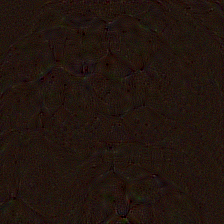

In [23]:
import numpy as np
noise_img=np.random.random((224,224,3))*20+128
noise_img=tf.cast(noise_img,dtype=tf.float32)

convet_img = run_deep_dream_simple(img=noise_img, 
                                  steps=512, step_size=0.01)

In [33]:
img = tf.keras.applications.vgg19.preprocess_input(noise_img)
#img = tf.convert_to_tensor(img)
loss, img = deepdream(img, 512, 0.01)

Tracing


In [35]:
print(np.min(img))
print(np.max(img))

0.0
69.67287


In [25]:
convet_img

<tf.Tensor: shape=(224, 224, 3), dtype=uint8, numpy=
array([[[26, 25, 16],
        [31, 29, 13],
        [39, 17,  6],
        ...,
        [46, 24,  8],
        [26, 15, 18],
        [41, 27,  7]],

       [[37, 12, 16],
        [31, 14, 18],
        [35, 24, 13],
        ...,
        [38, 30,  0],
        [38, 13,  2],
        [28, 29, 20]],

       [[44, 19, 12],
        [42, 15, 17],
        [35, 12, 12],
        ...,
        [29, 30, 16],
        [32, 26, 13],
        [32, 30, 21]],

       ...,

       [[24, 10, 12],
        [33, 21, 11],
        [43, 12, 12],
        ...,
        [26, 12, 16],
        [41, 14, 12],
        [37, 13, 20]],

       [[39, 16,  5],
        [28, 13, 10],
        [33, 22, 23],
        ...,
        [32, 18, 17],
        [29, 31,  9],
        [41, 23,  7]],

       [[26, 26, 22],
        [29, 14, 14],
        [40, 26, 15],
        ...,
        [37, 22,  5],
        [31, 24, 16],
        [34, 30, 23]]], dtype=uint8)>